In [1]:
# Setting optimal number of threads for kmeans:
%env OMP_NUM_THREADS=1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
import pylab
import os
# allow us to see results under cell code
%matplotlib inline

env: OMP_NUM_THREADS=1


### Set working directory:

#### Check current working directory:

In [2]:
pwd

'C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering'

#### Setting desire working directory
(Provide path to the folder containing the .csv file from fiji)

In [3]:
os.chdir('C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering\\training_csv')

#### Check if provided path leads to desired directory:

In [4]:
os.getcwd()

'C:\\Users\\Alek\\Desktop\\Github_commits\\Trajectory_clustering\\training_csv'

### Setting filenames:

#### tracks_df - .csv file from fiji (or imageJ) containing information about generated tracks from TrackMate plugin
#### spots_df - .csv file from fiji (or imageJ) containing information about spots whithin every track
#### directory_name - name of the new directory that the workflow will create containing all output information and generated data frames in the form of .csv files

In [5]:
tracks_df = 'export_tracks_analiza_filtered.csv' 

spots_df = 'export_spots_analiza_filtered.csv'

# Please stick with convention of naming example: "TA_training_csv"
directory_name = 'TA_training_csv'

### Importing data from .csv to the data frame:

In [6]:
# Reading file with proper encoding form fiji:

raw_data = pd.read_csv(tracks_df, encoding = 'cp1250')
raw_data_spots = pd.read_csv(spots_df, encoding = 'cp1250')

# Fillling na values:
raw_data.fillna(0)

# Creating the df from interesting columns:
df_from_raw = raw_data[['LABEL', 'TRACK_ID','TRACK_MIN_SPEED', 'TRACK_MEDIAN_SPEED',
                          'TRACK_STD_SPEED', 'TOTAL_DISTANCE_TRAVELED',
                          'CONFINEMENT_RATIO', 'MEAN_STRAIGHT_LINE_SPEED',
                          'LINEARITY_OF_FORWARD_PROGRESSION',
                          'MEAN_DIRECTIONAL_CHANGE_RATE']].copy()

### Adjusting the data frame content: removing exces rows, converting types reseting index etc. 

In [7]:
# Droping first 3 row because of insuficient values:
df_dropped = df_from_raw.drop(df_from_raw.index[[0,1,2]])

# Setting the proper index order:
df_dropped = df_dropped.reset_index(level=None, drop=True)

# Setting proper data types of values:
# By use of to numeric it was able tooverlap the problem with commas.
df_w_floats = df_dropped.iloc[:, 2:10].apply(pd.to_numeric)
# We also adding the label column with the names of tracks changed to string
df_w_floats['LABEL'] = df_dropped['LABEL'].astype('string')
df_w_floats['TRACK_ID'] = df_dropped['TRACK_ID'].astype('int')
# df_w_floats.info()

# Creating sub-df without fiji labels:
df_no_Flabels = df_w_floats.copy()
df_no_Flabels = df_no_Flabels.drop(['LABEL', 'TRACK_ID'], axis = 1)
#df_no_Flabels.info()

### Making new directory for output provided by the workflow:

In [8]:
# getting the absolute path of the current working directory
current_dir = os.getcwd()

# creating path to new folder:
new_folder_path = os.path.abspath(os.path.join(current_dir, directory_name))

# Checking if the directory already exists
if not os.path.exists(new_folder_path): 
    # create the new folder
    os.mkdir(new_folder_path)
else:
    print(f"The directory {new_folder_path} already exists, using it instead.")
    
# set the new folder as the current working directory
os.chdir(new_folder_path)

# saving .csv to new folder:
df_w_floats.to_csv('df_w_floats.csv')
df_no_Flabels.to_csv('df_no_Flabes.csv')
raw_data_spots.to_csv('raw_spots_data.csv')

The directory C:\Users\Alek\Desktop\Github_commits\Trajectory_clustering\training_csv\TA_training_csv already exists, using it instead.


### Performing the spearman correlation of all features:

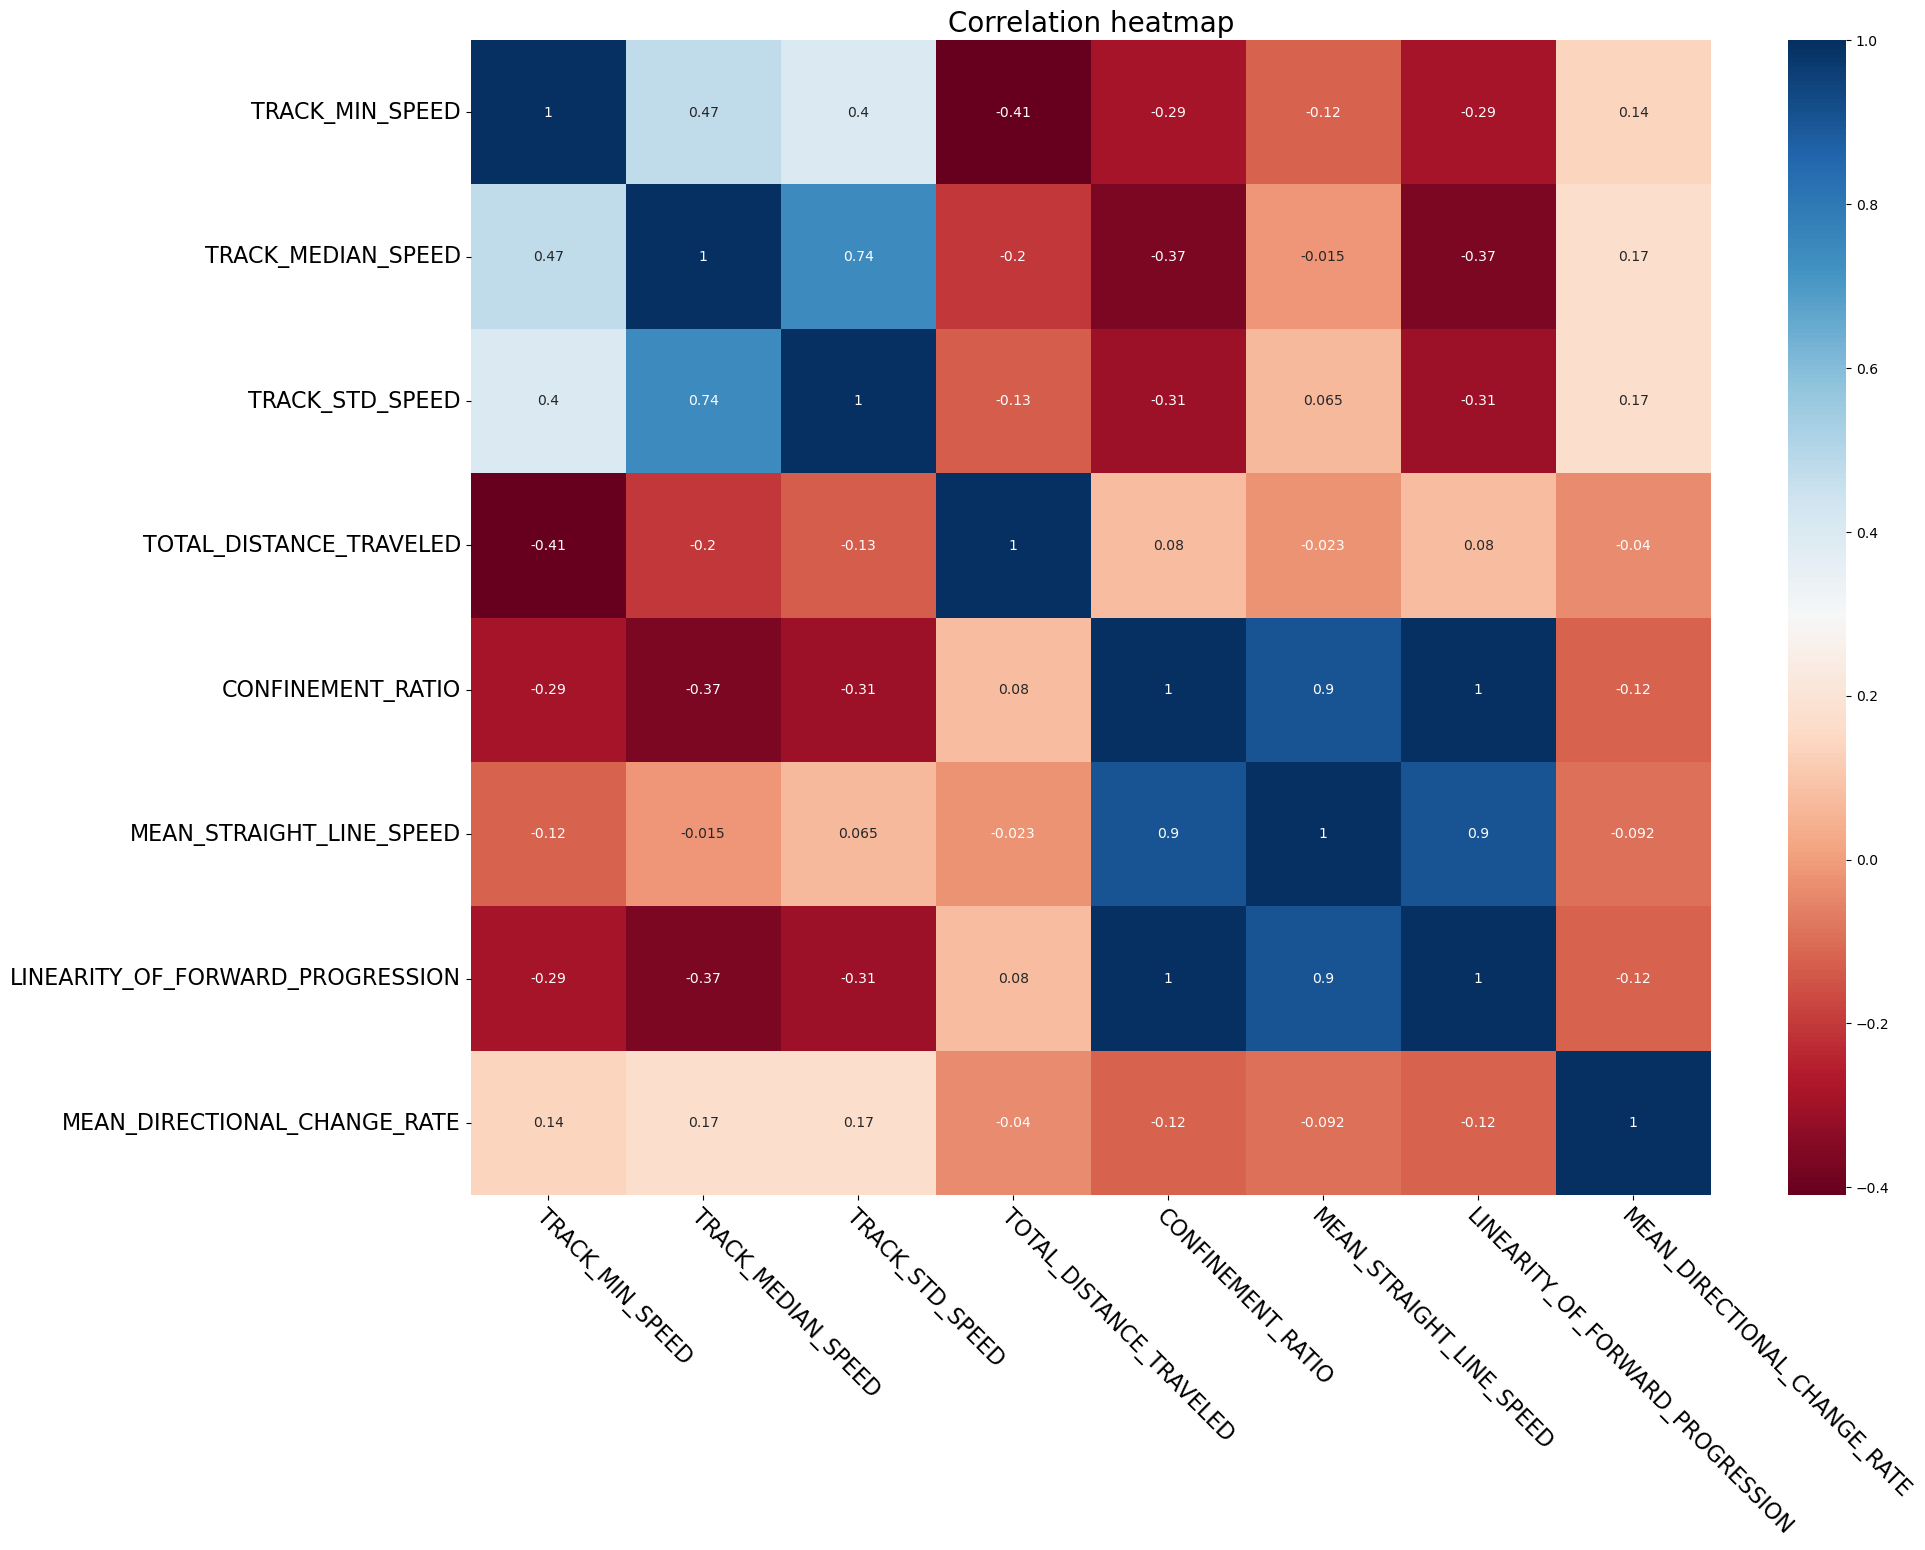

In [9]:
plt.figure(figsize=(20,15))
sns.heatmap(df_no_Flabels.corr(method='spearman'),
            annot=True, cmap='RdBu')
plt.title('Correlation heatmap', fontsize=20)
plt.yticks(rotation=0, fontsize = 16)
plt.xticks(rotation=-45, ha='left', rotation_mode='anchor', fontsize = 16)
plt.savefig("heatmap_spearman_out.jpg")
plt.show()

### Performing scaling of the data:


In [10]:
# Scaling data with robust scaler:

# Creating robustscaler object:
scaler_robust = RobustScaler()

# Separating the label from data frame:
label = df_w_floats['LABEL']

# Fit and transform the feature data:
scaled_features = scaler_robust.fit_transform(df_no_Flabels)

# Creating new data frame with the scaled features and the label column:
df_scaled = pd.DataFrame(scaled_features, columns=df_no_Flabels.columns)
df_scaled.insert(0, 'Label', label)

# saving the scaled data to csv
df_scaled.to_csv("tracks_df_scaled.csv")

### Prepering data to clustering:

From further testing the best performance in clustering for this analysis
was achived by reducing dimensionality of data set to 2 features and limiting cluster numbers to 2 (all concluded testing is provided in another script free to use) but for checking different purposes all data frame was scaled and the functions will allow changeing the features to perform different outputs. 

List of all possible features to use:
1. TRACK_MIN_SPEED
2. TRACK_MEDIAN_SPEED
3. TRACK_STD_SPEED
4. TOTAL_DISTANCE_TRAVELED
5. CONFINEMENT_RATIO
6. MEAN_STRAIGHT_LINE_SPEED
7. LINEARITY_OF_FORWARD_PROGRESSION
8. MEAN_DIRECTIONA_CHANGE_RATE

For my analysis best performance was achived by using the features 5 and 7. Please have in considaration that it is possible to change and use of other features may yield different outcome.

In [11]:
# Setting the data frame for K-Means and hierarchical clustering:
df_to_clustering = df_scaled[['CONFINEMENT_RATIO', 'MEAN_DIRECTIONAL_CHANGE_RATE']].copy()

#### Performing K-Means clustering on fixed parameters:

In [12]:
def perform_k_means_clustering(df):
    # Performing kmeans for provided dataframe:
    # kmeans_fp - means fixed parameters
    kmeans_fp = KMeans(n_clusters = 2, init='k-means++', n_init = 50,
                      max_iter = 10000, random_state = 1)
    kmeans_fp.fit_predict(df)
    
    # Getting the labels and centroids:
    labels = kmeans_fp.labels_
    centroids = kmeans_fp.cluster_centers_
    
    return labels, centroids 

In [13]:
def plot_kmeans(labels, data, centroids):
    
    """
    Plots the data points and centroids for KMeans clustering.

    Args:
    labels (numpy.ndarray): The cluster labels for each data point.
    data (pandas.DataFrame): The input data used for clustering.
    centroids (numpy.ndarray): The centroids of each cluster.

    Returns:
    None
    """
    try:
        # Check that labels are a numpy aray:
        if not isinstance(labels, np.ndarray):
            raise TypeError('Labels must be a numpy array.')
        
        # Check that the data is a pandas Data frame:
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the centroids are a numpy array:
        if not isinstance(centroids, np.ndarray):
            raise TypeError('Centroids must be a numpay array')
            
        # Check that the data and the centroids have two columns:
        if data.shape[1] != 2 or centroids.shape[1] != 2:
            raise ValueError("Data and centroids must have two columns")
        
        # Creating the scatter plot od the data points:
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c = labels, cmap = 'viridis')

        # Ploting the centroids as black stars:
        plt.scatter(centroids[:, 0], centroids[:, 1], c ='black', marker = '*',
                   s = 150)

        list_of_features = list(data.columns)
        # Set the axis:
        plt.title(f"KMeans clustering\n({list_of_features[0]} vs. {list_of_features[1]})")
        plt.xlabel(list_of_features[0])
        plt.ylabel(list_of_features[1])
        
        # Saving the plot:
        plt.savefig(f'kmeans_{list_of_features[0]}_vs_{list_of_features[1]}.png')

        # Showing the plot:
        plt.show()
    
    except Exception as e:
        print(f"An error occured: {e}")

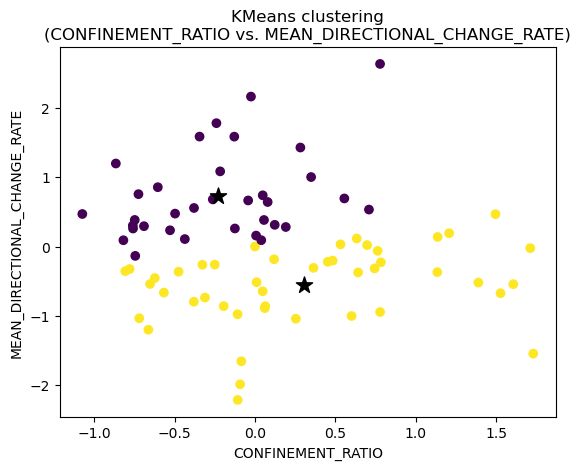

In [14]:
labels, centroids = perform_k_means_clustering(df_to_clustering)
plot_kmeans(labels, df_to_clustering, centroids)

#### Performing hierarchical clustering:

In [15]:
def hierarchical_clustering(df):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the data and the centroids have two columns:
        if df.shape[1] != 2:
            raise ValueError("Data must have two columns")
        
        # Calculate the pairwais distance matrix
        dist_matrix = linkage(df.values, method = 'ward', metric='euclidean')
        
        # Plot the dendrogram:
        plt.title(f"Dendrogram of hierarchical clustering \n({df.columns[0]} vs. {df.columns[1]})")
        dendrogram(dist_matrix)
        plt.xlabel('Data points')
        plt.ylabel('Distance')
        
        # Assing cluster labels based on a distance treshhold
        # Substraction is made just for starting from 0 not from 1
        clusters = fcluster(dist_matrix, t=7, criterion = 'distance')-1
        
        plt.savefig(f'dendrogram_{df.columns[0]}_vs_{df.columns[1]}.png')
        
        return dist_matrix, clusters
    
    except Exception as e:
        print(f"An error occurs: {e}")

In [16]:
def plot_hierarchical_data(df, labels):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
            
        # Check that the data and the centroids have two columns:
        if df.shape[1] != 2:
            raise ValueError("Data must have two columns")
            
        # Plot the clustered data
        plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c = labels, cmap = 'viridis')
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[1])
        plt.title(f"Hierarchical Clustering \n({df.columns[0]} vs. {df.columns[1]})")
        plt.savefig(f"hierarchical_{df.columns[0]}_vs_{df.columns[1]}.png")
        plt.show()
        
    except Exception as e:
        print(f"An error occurs: {e}") 

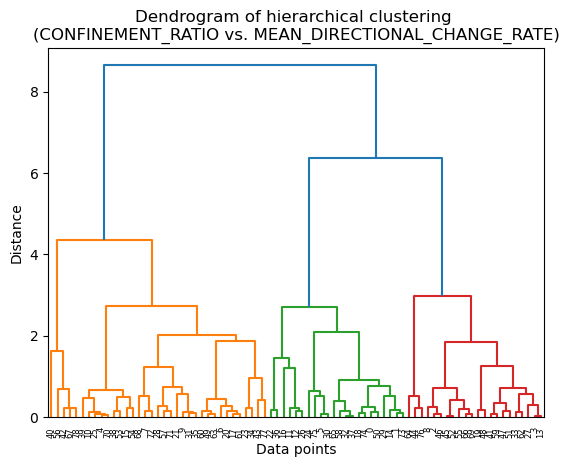

In [17]:
dist_matrix, hierarchical_labels = hierarchical_clustering(df_to_clustering)

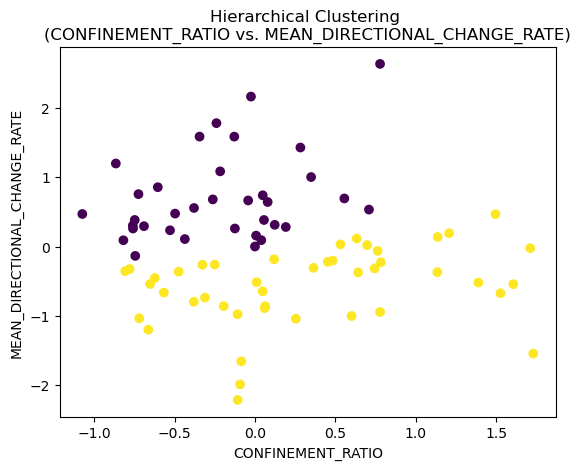

In [18]:
plot_hierarchical_data(df_to_clustering, hierarchical_labels)

#### Sorting the track_names by the clustering group:

##### Kmeans:

In [19]:
def get_kmeans_groups(df_w_track_names, cluster_labels):
    df = pd.DataFrame(df_w_track_names['Label'].copy())
    df['Cluster_labels'] = cluster_labels
    
    # Group the data by the cluster_labels column and get the list of track names
    # for each cluster:
    cluster_dict = df.groupby('Cluster_labels')['Label'].apply(list).to_dict()
    
    return cluster_dict

In [20]:
kmeans_dict = get_kmeans_groups(df_scaled, labels)

##### Hierarchical:

In [21]:
def get_hierarchical_groups(df_w_track_names, hierarchical_labels):
    df = pd.DataFrame(df_w_track_names['Label'].copy())
    df['Cluster_labels'] = hierarchical_labels
    
    # Group the data by the cluster_labels column and get the list of track names
    # for each cluster:
    cluster_dict = df.groupby('Cluster_labels')['Label'].apply(list).to_dict()
    
    return cluster_dict

In [22]:
hierarchical_dict = get_hierarchical_groups(df_scaled, hierarchical_labels)

#### Creating data frames with columns taken to the clustring and their label values:

In [23]:
# For Kmeans:
df_after_kmeans = pd.DataFrame(df_to_clustering.copy())
df_after_kmeans['Cluster_labels'] = labels

# For hierarchical:
df_after_hierarchical = pd.DataFrame(df_to_clustering.copy())
df_after_hierarchical['Cluster_labels'] = hierarchical_labels

### Comparison the groups after clustering:

#### Performing pie plot of the clusters after kmeans

In [24]:
from collections import Counter

def plot_clusters_pie(cluster_dict: dict, algorithm_name: str):
    try:
        # Count the number of elements in each cluster:
        cluster_counts = Counter({k: len(v) for k, v in cluster_dict.items()})
        
        # Create a pie plot:
        labels = [f'Clusters {k}' for k in cluster_counts.keys()]
        sizes = list(cluster_counts.values())
        
        # Setting to show the number of tracks in each group:
        def autopct_func(pct):
            total = sum(cluster_counts.values())
            count = int(round(pct*total/100))
            return f'{pct:.1f}%\n({count})'
        
        plt.pie(sizes, labels = labels, autopct = autopct_func)
        plt.axis('equal')
        plt.title(f'Group distribution after {algorithm_name}')
        plt.savefig(f'pie_plot_of_{algorithm_name}_groups.png')
        plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        plt.close()

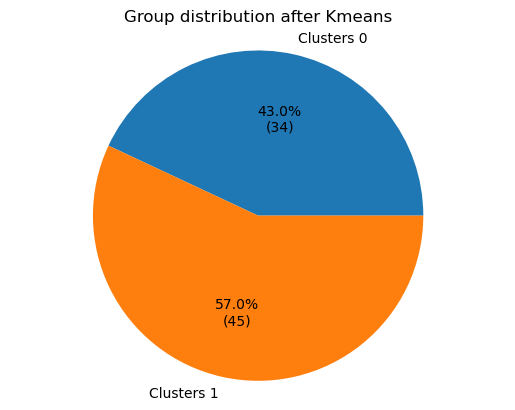

In [25]:
plot_clusters_pie(kmeans_dict, 'Kmeans')

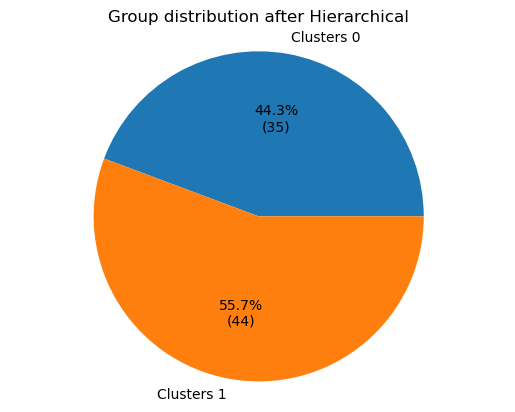

In [26]:
plot_clusters_pie(hierarchical_dict, 'Hierarchical')

#### Comparing the cluster groups:

In [27]:
def compare_dicts(dict1, dict2):
    try:
        # get the common keys from both dictionaries
        common_keys = set(dict1.keys()) & set(dict2.keys())

        # compare the values of each common key
        for key in common_keys:
            if dict1[key] != dict2[key]:
                # find the differences between the two lists
                set1 = set(dict1[key])
                set2 = set(dict2[key])
                differences = set1.symmetric_difference(set2)

                # print the key and the differing values
                print(f"Differences in group {key}:")
                for val in differences:
                    if val in set1 and val not in set2:
                        print(f"Value '{val}' only in first dictionary")
                    elif val in set2 and val not in set1:
                        print(f"Value '{val}' only in second dictionary")
            else:
                print(f"Group {key} is identical in both dictionaries")

        # print the keys that are only present in one dictionary
        keys_only_in_dict1 = set(dict1.keys()) - common_keys
        keys_only_in_dict2 = set(dict2.keys()) - common_keys
        if keys_only_in_dict1:
            print(f"The following groups are only in the first dictionary: {keys_only_in_dict1}")
        if keys_only_in_dict2:
            print(f"The following groups are only in the second dictionary: {keys_only_in_dict2}")
    except Exception as e:
        print(f"An errot occured: {e}")

In [28]:
# Calling compare dicts to chcek the differences in the cluster groups:
compare_dicts(kmeans_dict, hierarchical_dict)

Differences in group 0:
Value 'Track_50' only in second dictionary
Differences in group 1:
Value 'Track_50' only in first dictionary


#### Comparing features accros the clusters:

In [29]:
def plot_boxplot_sns(df):
    try:
        # Check that the data is a pandas Data frame:
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')

        # Getting the names of the features to avoid hard coding the names:
        feature_names = list(df.columns)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        data_0 = df[df[str(feature_names[2])] == 0][[str(feature_names[0]), str(feature_names[1])]]
        data_1 = df[df[str(feature_names[2])] == 1][[str(feature_names[0]), str(feature_names[1])]]

        # Calculating the standard deviation for whiskers:
        std_0 = data_0.std().values
        std_1 = data_1.std().values

        axs[0] = sns.boxplot(data=[data_0[str(feature_names[0])], data_1[str(feature_names[0])]], 
                             ax=axs[0], notch=True, whis=(std_0[0], std_0[0]) )
        axs[1] = sns.boxplot(data=[data_0[str(feature_names[1])], data_1[str(feature_names[1])]], 
                             ax=axs[1], notch=True, whis=(std_1[0], std_1[0]) )

        axs[0].set_title(f"{feature_names[0]} by Cluster")
        axs[1].set_title(f"{feature_names[1]} by Cluster")
        plt.show()
        
    except Exception as e:
        print(f"An error occured: {e}")

When using the parameter whis with a tuple of the same value for the upper and lower whiskers, such as whis=(std_0[0], std_0[0]), the upper whisker may not be visible if there are any outliers above the upper whisker. This is because the upper whisker is drawn to the maximum data point within the whisker length, which is determined by the range of the data and the specified whis value. However, if there are any data points beyond the upper whisker length, they will be plotted as outliers, and the upper whisker will not be visible.

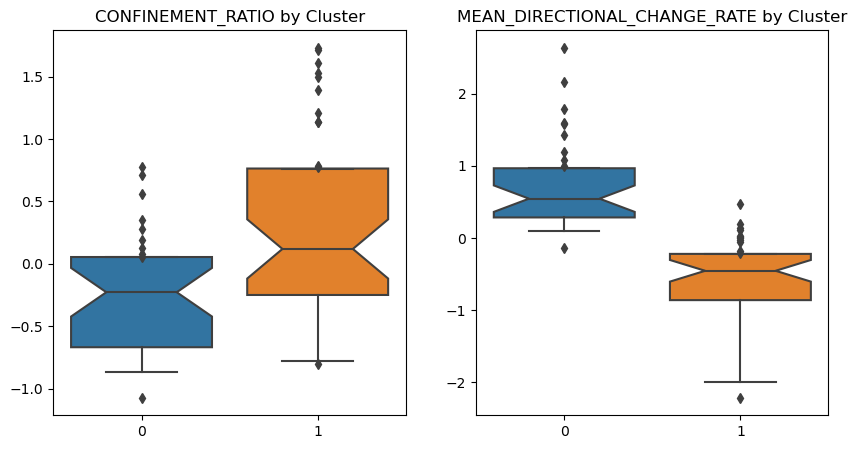

In [30]:
plot_boxplot_sns(df_after_kmeans)

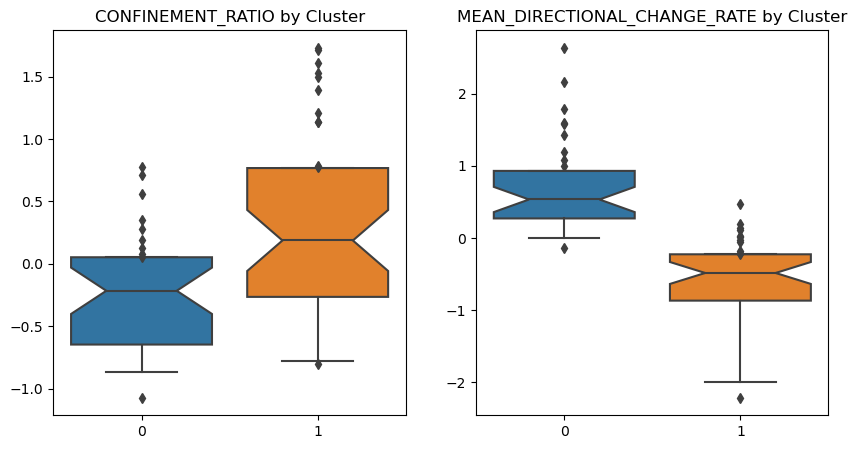

In [31]:
plot_boxplot_sns(df_after_hierarchical)

### Preapring spots data frame from raw:

In [32]:
# Now there should be added the parsing of the spots data frame to
# aquire the gruped df of the tracks with all the points accros
# it's movement.

In [33]:
# Creating data frame with the track label, start_pos, end_pos, track_id
df_track_start_end_info = raw_data[['LABEL', 'TRACK_ID', 
                                'TRACK_START', 'TRACK_STOP']].copy()

# Droping unnecessary rows:
df_track_start_end_info.drop(df_track_start_end_info.index[[0,1,2]],
                              inplace = True)

# Reseting index of the whole data frame:
df_track_start_end_info.reset_index(level = None, drop=True, inplace = True)

# Setting proper types of the cells:
df_start_end_tracks = df_track_start_end_info.iloc[:, 1:4].apply(pd.to_numeric)
df_start_end_tracks['Label'] = df_track_start_end_info['LABEL'].astype('string')

# Performing operations on the .csv file with the information about spots:
df_only_spots = raw_data_spots[['TRACK_ID', 'POSITION_X', 'POSITION_Y',
                                'POSITION_T', 'FRAME']].copy()

# Droping unnecesary rows:
df_only_spots.drop(df_only_spots.index[[0,1,2]], inplace=True)

# Reseting the index of the whole data frame:
df_only_spots.reset_index(level=None, drop=True, inplace = True)

# Setting proper types:
df_all_spots = df_only_spots.iloc[:, 0:5].apply(pd.to_numeric)

In [34]:
# Joining two tables on track_id:
df_spots_merged = pd.merge(df_start_end_tracks, df_all_spots, how = 'inner',
                          on='TRACK_ID',
                          suffixes=['','_'])[['Label', 'TRACK_ID', 'TRACK_START',
                                             'TRACK_STOP', 'FRAME', 'POSITION_X',
                                             'POSITION_Y', 'POSITION_T']]

In [35]:
# Sorting merged data frame by the time position for each track:
gruped_tracks = df_spots_merged.sort_values(['TRACK_ID','POSITION_T'],ascending=True).groupby('TRACK_ID')
sorted_tracks_df = gruped_tracks.apply(lambda x: x)
sorted_tracks_df.head()

,Label,TRACK_ID,TRACK_START,TRACK_STOP,FRAME,POSITION_X,POSITION_Y,POSITION_T
75,Track_0,0,0.0,202.0,0,67.146850,85.546652,0.0
149,Track_0,0,0.0,202.0,1,67.008878,85.449081,1.0
14,Track_0,0,0.0,202.0,2,66.915325,85.566201,2.0
98,Track_0,0,0.0,202.0,3,66.751480,85.136118,3.0
167,Track_0,0,0.0,202.0,4,66.827460,85.078060,4.0


In [36]:
# After this there should be added function to generating points in straight
# line from the start and finish x,y coords of the tracks

In [53]:
# Making dictionary out of the sorted spots data frame:
def track_positions_dict(spots_df):
    try:
        # checking if provided variable is a data fream
        if not isinstance(spots_df, pd.DataFrame):
            raise TypeError('Data must be a pandas DataFrame.')
        
        # Grouping data from data frame by the track_name:
        grouped_data = spots_df.groupby('Label')
        
        # creating the dictionary with the track name and all its pos_x, 
        # pos_y as tuples:
        result_dict = {name: list(zip(group['POSITION_X'], group['POSITION_Y'])) for name, group in grouped_data}
        
        # returning the result:
        return result_dict
    except Exception as e:
        print(f'An error occurs: {e}')

In [54]:
# Calling function to generate the dictionary of position in track:
track_positions_dict = track_positions_dict(sorted_tracks_df)

# Testing the generated dictionary:
# track_positions_dict['Track_0']

In [59]:
# Function generating coordinates in straight line to the start, end
# coordinates of a track:
def generating_points_in_line(x_A, y_A, x_B, y_B, n_samples):
    try:
        # Chceking if provided coordinates are in vertical line:
        if x_A == x_B: # vertical line
            y_values = [y_A + i*(y_B-y_A)/(n_samples-1) for i in range(n_samples)]
            x_values = [x_A] * n_samples
        
        else: # non-vertical line
            x_values = [x_A + i*(x_B-x_A)/(n_samples-1) for i in range(n_samples)]
            y_values = [y_A + i*(y_B-y_A)/(n_samples-1) for i in range(n_samples)]

        # make sure first and last points are (x_A, y_A) and (x_B, y_B) respectively
        x_values[0] = x_A
        y_values[0] = y_A
        x_values[-1] = x_B
        y_values[-1] = y_B

        # create a list of tuples representing the generated points
        points = [(x_values[i], y_values[i]) for i in range(n_samples)]

        return points
    except Exception as e:
        print(f'An error occurs: {e}')

In [62]:
def generate_straight_line_for_all_tracks(tracks_dict: dict, df_start_end_tracks):
    try:
        # Setting the dictionary to stroe output of positions
        # and the name of track:
        track_in_line_pos_dict = {}
        
        # Iterate throught the tracks_dict keys:
        for name in tracks_dict.keys():
            # Setting the name variable:
            track_name = str(name)
            
            # Cacluclating the number of frames from start to finish of movement:
            df = df_start_end_tracks.copy()
            df = df.set_index('Label')
            start_frame = df.loc[track_name, 'TRACK_START'].astype('int32')
            end_frame = df.loc[track_name, 'TRACK_STOP'].astype('int32')
            
            # There have to be +1 addition in case to get all occurances 
            # of moving from first frame to last for example if track
            # starts moving in 0 frame and end in 200 frame function need
            # to generate 201 positions to cover all movemnt frames:
            move_frames = (end_frame-start_frame) + 1
            
            # Getting start and end coordinates:
            list_of_coords = tracks_dict[track_name]
            start_coords = list_of_coords[0]
            end_coords = list_of_coords[-1]
            
            # setting the start position variables:
            start_x, start_y = start_coords
            
            # setting the end positions:
            end_x, end_y = end_coords
            
            # Calling function to generate points in line to return each positions:
            tracks_move_in_line_list = generating_points_in_line(start_x, start_y, end_x, end_y, move_frames)
            
            # Adding all the lists to dict with the proper track names:
            track_in_line_pos_dict[str(name)]= tracks_move_in_line_list
            
        return track_in_line_pos_dict
    
    except Exception as e:
        print(f'An error occurs: {e}')

In [64]:
# Calling function to generate the line positions for all tracks:
straight_tracks_dict = generate_straight_line_for_all_tracks(track_positions_dict, df_start_end_tracks)

# Test checking of dictionary:
#straight_tracks_dict['Track_0']

[(67.14684976946333, 85.54665168801556),
 (67.1319747194368, 85.54579087813772),
 (67.11709966941027, 85.54493006825989),
 (67.10222461938373, 85.54406925838205),
 (67.0873495693572, 85.54320844850422),
 (67.07247451933067, 85.54234763862638),
 (67.05759946930414, 85.54148682874856),
 (67.0427244192776, 85.54062601887073),
 (67.02784936925107, 85.53976520899289),
 (67.01297431922454, 85.53890439911505),
 (66.99809926919801, 85.53804358923722),
 (66.98322421917148, 85.53718277935938),
 (66.96834916914494, 85.53632196948155),
 (66.95347411911841, 85.53546115960371),
 (66.93859906909188, 85.53460034972588),
 (66.92372401906533, 85.53373953984804),
 (66.9088489690388, 85.53287872997021),
 (66.89397391901227, 85.53201792009239),
 (66.87909886898574, 85.53115711021455),
 (66.8642238189592, 85.53029630033672),
 (66.84934876893267, 85.52943549045888),
 (66.83447371890614, 85.52857468058104),
 (66.8195986688796, 85.52771387070321),
 (66.80472361885307, 85.52685306082537),
 (66.78984856882654, 8

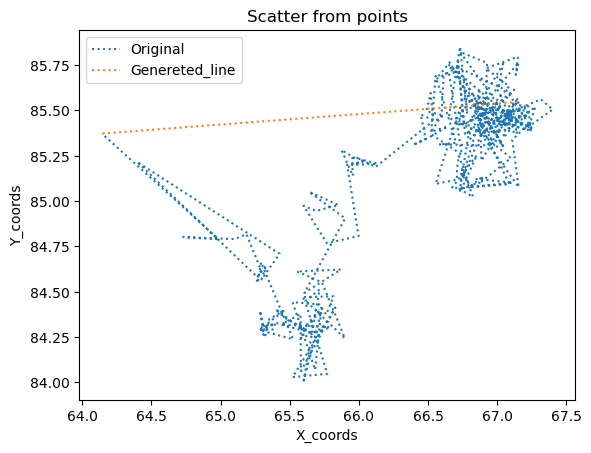

In [66]:
# Testing the generation of points:
# first_list:
x_values, y_values = zip(*track_positions_dict['Track_0'])
# Second_list:
x_2, y_2 = zip(*straight_tracks_dict['Track_0'])

# Creating a scatterL
plt.plot(x_values, y_values, linestyle= 'dotted', label = 'Original')
plt.plot(x_2, y_2, linestyle='dotted', label = 'Genereted_line')
plt.xlabel('X_coords')
plt.ylabel('Y_coords')
plt.legend()
plt.title('Scatter from points')

plt.show()

In [37]:
# After this there should be added function to calculate some distances 

In [38]:
df_all_spots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18498 entries, 0 to 18497
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TRACK_ID    18498 non-null  int64  
 1   POSITION_X  18498 non-null  float64
 2   POSITION_Y  18498 non-null  float64
 3   POSITION_T  18498 non-null  float64
 4   FRAME       18498 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 722.7 KB


In [39]:
df_all_spots

,TRACK_ID,POSITION_X,POSITION_Y,POSITION_T,FRAME
0,0,65.606465,84.493926,148.0,148
1,0,66.725150,85.414498,53.0,53
2,0,65.282319,84.288380,187.0,187
3,0,66.731259,85.048971,42.0,42
4,0,66.535793,85.466081,129.0,129
...,...,...,...,...,...
18493,1355,135.112239,72.324189,386.0,386
18494,1355,135.038800,72.204136,398.0,398
18495,1355,134.617692,71.736037,383.0,383
18496,1355,134.895214,71.898385,401.0,401


In [40]:
df_start_end_tracks

,TRACK_ID,TRACK_START,TRACK_STOP,Label
0,0,0.0,202.0,Track_0
1,2,0.0,328.0,Track_2
2,7,0.0,74.0,Track_7
3,9,0.0,169.0,Track_9
4,10,0.0,198.0,Track_10
...,...,...,...,...
74,1019,252.0,419.0,Track_1019
75,1187,306.0,435.0,Track_1187
76,1324,351.0,499.0,Track_1324
77,1327,352.0,499.0,Track_1327


In [41]:
df_spots_merged

,Label,TRACK_ID,TRACK_START,TRACK_STOP,FRAME,POSITION_X,POSITION_Y,POSITION_T
0,Track_0,0,0.0,202.0,148,65.606465,84.493926,148.0
1,Track_0,0,0.0,202.0,53,66.725150,85.414498,53.0
2,Track_0,0,0.0,202.0,187,65.282319,84.288380,187.0
3,Track_0,0,0.0,202.0,42,66.731259,85.048971,42.0
4,Track_0,0,0.0,202.0,129,66.535793,85.466081,129.0
...,...,...,...,...,...,...,...,...
18493,Track_1355,1355,362.0,489.0,386,135.112239,72.324189,386.0
18494,Track_1355,1355,362.0,489.0,398,135.038800,72.204136,398.0
18495,Track_1355,1355,362.0,489.0,383,134.617692,71.736037,383.0
18496,Track_1355,1355,362.0,489.0,401,134.895214,71.898385,401.0


In [42]:
df_spots_merged.to_csv('test_merged.csv')

In [43]:
sorted_tracks_df.to_csv('test_sorted.csv')

In [52]:
sorted_tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18498 entries, 75 to 18436
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        18498 non-null  string 
 1   TRACK_ID     18498 non-null  int64  
 2   TRACK_START  18498 non-null  float64
 3   TRACK_STOP   18498 non-null  float64
 4   FRAME        18498 non-null  int64  
 5   POSITION_X   18498 non-null  float64
 6   POSITION_Y   18498 non-null  float64
 7   POSITION_T   18498 non-null  float64
dtypes: float64(5), int64(2), string(1)
memory usage: 1.3 MB
